<a href="https://colab.research.google.com/github/agmCorp/colab/blob/main/ROI-barcode-final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
import cv2
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt
import io

# Función para mostrar imágenes en Colab
def mostrar_imagen(titulo, imagen, es_bgr=False):
    """Muestra una imagen usando matplotlib."""
    plt.figure(figsize=(8, 6))
    if es_bgr:
        plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(imagen, cmap='gray')
    plt.title(titulo)
    plt.axis('off')
    plt.show()

# Sube los archivos a Colab
print("Por favor, sube las imágenes que quieres procesar:")
uploaded = files.upload()

Por favor, sube las imágenes que quieres procesar:


Saving IMG_8938.png to IMG_8938 (1).png



--- Procesando imagen: IMG_8938 (1).png ---


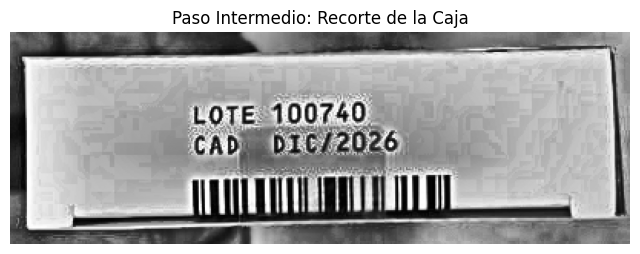

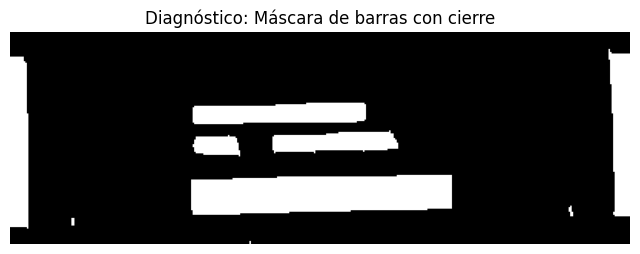

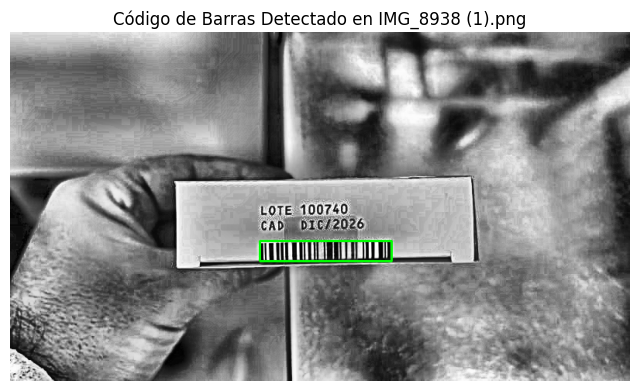

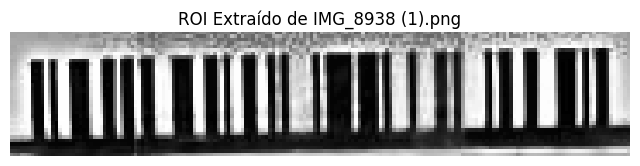

In [55]:
import cv2
import numpy as np

def encontrar_codigo_por_recorte(nombre_archivo, datos_imagen):
    """
    CORRECCIÓN:
    1. Detecta la caja blanca del medicamento.
    2. RECORTA esa región de la imagen original (enfoque no destructivo).
    3. Busca el código de barras únicamente dentro de ese recorte.
    """

    print(f"\n--- Procesando imagen: {nombre_archivo} ---")

    # Cargar la imagen en escala de grises
    imagen_np = np.frombuffer(datos_imagen, np.uint8)
    gris = cv2.imdecode(imagen_np, cv2.IMREAD_GRAYSCALE)
    imagen_para_dibujar = cv2.cvtColor(gris, cv2.COLOR_GRAY2BGR)

    # --- PASO 1 y 2: ENCONTRAR Y RECORTAR LA CAJA ---
    # Usamos un umbral más bajo y un kernel más grande para el blur para asegurar que la caja se detecte como un solo objeto grande,
    # incluso si hay texto u otras marcas.
    blur = cv2.GaussianBlur(gris, (11, 11), 0) # Kernel más grande para suavizar más

    # Ajustamos el umbral para ser un poco más inclusivo con los blancos
    _, umbral_caja = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY)
    contornos_caja, _ = cv2.findContours(umbral_caja, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contornos_caja) == 0:
        print("No se pudo encontrar el contorno de la caja del medicamento.")
        return

    caja_contour = max(contornos_caja, key=cv2.contourArea)

    # --- PASO 2: RECORTAR LA REGIÓN DE LA CAJA ---
    (x_caja, y_caja, w_caja, h_caja) = cv2.boundingRect(caja_contour)

    # Expandir un poco la caja para asegurarnos de que el código de barras esté dentro
    margen_caja = 10
    x_caja = max(0, x_caja - margen_caja)
    y_caja = max(0, y_caja - margen_caja)
    w_caja = min(gris.shape[1] - x_caja, w_caja + 2 * margen_caja)
    h_caja = min(gris.shape[0] - y_caja, h_caja + 2 * margen_caja)

    caja_recortada = gris[y_caja:y_caja+h_caja, x_caja:x_caja+w_caja]

    if caja_recortada.size == 0:
        print("La caja recortada está vacía después de los ajustes.")
        return

    # Debug
    mostrar_imagen("Paso Intermedio: Recorte de la Caja", caja_recortada)

    # --- PASO 3: DETECCIÓN DE DENSIDAD DE BARRAS ---

    # 1. Usar el gradiente para resaltar las barras verticales
    gradX = cv2.Sobel(caja_recortada, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
    gradiente = np.absolute(gradX)
    (minVal, maxVal) = (np.min(gradiente), np.max(gradiente))
    gradiente = (255 * ((gradiente - minVal) / (maxVal - minVal))).astype("uint8")

    # 2. Desenfoque y umbral para obtener una máscara binaria de las barras
    # Usamos un kernel horizontal ancho para conectar las barras del código de barras
    # y un kernel vertical más alto para que las barras sean "altas".
    gradiente_cerrado = cv2.morphologyEx(gradiente, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (21, 5)))
    gradiente_cerrado = cv2.threshold(gradiente_cerrado, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Realizamos otra operación de cierre para rellenar los huecos entre las barras del código
    gradiente_cerrado = cv2.morphologyEx(gradiente_cerrado, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (21, 5)))

    mostrar_imagen("Diagnóstico: Máscara de barras con cierre", gradiente_cerrado)

    # 3. Encontrar contornos en la máscara procesada
    contornos, _ = cv2.findContours(gradiente_cerrado.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Asegurarse de que se encontró al menos un contorno
    if len(contornos) == 0:
        print("No se encontraron contornos de barras después del procesamiento de gradiente.")
        return

    # 4. Encontrar el contorno más grande, que debería ser el código de barras
    c = sorted(contornos, key=cv2.contourArea, reverse=True)[0]

    # Calcular el rectángulo delimitador del contorno más grande
    (x_bc, y_bc, w_bc, h_bc) = cv2.boundingRect(c)

    # --- PASO 4: EXTRAER Y MOSTRAR RESULTADOS (adaptado) ---
    # Ajustamos las coordenadas a la imagen original
    x_final = x_caja + x_bc
    y_final = y_caja + y_bc

    cv2.rectangle(imagen_para_dibujar, (x_final, y_final), (x_final + w_bc, y_final + h_bc), (0, 255, 0), 2)

    # Expandir el ROI final un poco para asegurar que todo el código de barras esté incluido
    margen = 5
    roi_final = gris[max(0, y_final-margen) : min(gris.shape[0], y_final+h_bc+margen),
                       max(0, x_final-margen) : min(gris.shape[1], x_final+w_bc+margen)]

    mostrar_imagen(f"Código de Barras Detectado en {nombre_archivo}", imagen_para_dibujar, es_bgr=True)
    if roi_final.size > 0:
        mostrar_imagen(f"ROI Extraído de {nombre_archivo}", roi_final)
    else:
        print("El ROI final extraído está vacío.")

# --- Bucle principal para procesar todas las imágenes subidas ---
for fn, content in uploaded.items():
    encontrar_codigo_por_recorte(fn, content)